reference video: https://www.youtube.com/watch?v=jztwpsIzEGc&t=981s

In [1]:
import cv2
from matplotlib import pyplot as plt

## Organising image classes

We now try to take the data folder, and split it into multiple data folders, each of these folders containing one individual picture classification

BEFORE RUNNING THIS STEP: please have image folder in parent directory and data_classes folder in experimental


In [2]:
import os
import shutil

classes=set()

for image in os.listdir("../images"):
    classes.add(image[:2])

#the following code extracts the numerical part of the class name
#this is because some of the numeric values are 1 digit and will leave an underscore behind in the string
#this would filter out the numeric portion
newlist=[int(''.join(filter(str.isdigit, classname))) for classname in classes]


parent_dir="../experimental/data_classes"
imagePath="../images"

for num in (newlist):
    dir_path = os.path.join(parent_dir, str(num))
    os.makedirs(dir_path, exist_ok=True)
    print(f"Directory {dir_path} created.")


for imagefilename in os.listdir(imagePath):
    newstring = "".join(filter(str.isdigit, imagefilename[:2]))
    targetdirectory=os.path.join(parent_dir, newstring)
    newimagepath=os.path.join(imagePath, imagefilename)
    shutil.move(newimagepath, targetdirectory)
    print("image moved")


## Image processing and visualisation

image resizing testing, using this technique we can successfully resize the image to a standard size of 128,128,3, without sacrificing any major features of the photo 

(402, 491, 3)
(128, 128, 3)


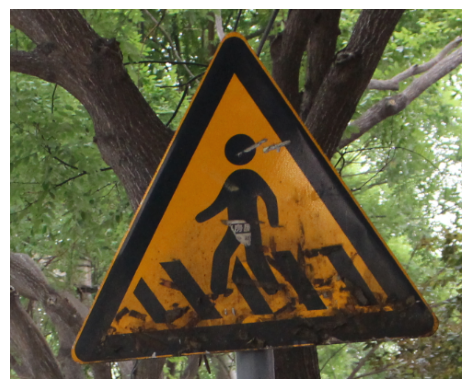

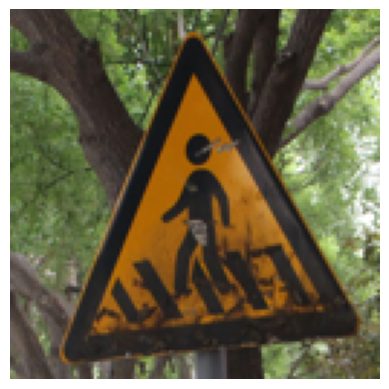

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

'''
def load_and_resize_image(image_path, new_size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(new_size)
    img.save(image_path.replace("data_classes", "resized_image"))  # Saving in new location
    return img

# Load and resize an example image
example_image_path = '../experimental/data_classes/10/10_577.png'
img_resized = load_and_resize_image(example_image_path)
'''

old_img_array=cv2.imread('../experimental/data_classes/10/10_577.png')
new_img_array=cv2.imread("../experimental/resized_image/image.png")
print(old_img_array.shape)
print(new_img_array.shape)


plt.imshow(cv2.cvtColor(old_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

plt.imshow(cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

Now we try to construct an image daatset from our image_directory, which is already nicely split up for us. There is a keras library for this:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

## Data Preparation for model training

TensorFlow api documentation for data augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation

In [5]:
import tensorflow as tf

data=tf.keras.utils.image_dataset_from_directory("../experimental/data_classes",
                                                image_size=(256, 256),
                                                batch_size=64,
                                                )

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), 
    tf.keras.layers.RandomRotation(0.2),                    
    tf.keras.layers.RandomZoom(0.2),                       
    tf.keras.layers.RandomContrast(0.2)                    
])

data = data.map(lambda x, y: (data_augmentation(x), y))

data_iterator= data.as_numpy_iterator()
batch=data_iterator.next()
print(batch[0].shape) #independent variables i.e pixel values
print(batch[1].shape) #y labels


Found 4896 files belonging to 23 classes.
(64, 256, 256, 3)
(64,)


lets have a look at the max and min values of each pixel, we can see that pixels take a max and min value of 255 and 0 respectively. This means that to normalise, we simply take the values and divide it by range: 255

In [6]:
print("Max value of pixels: ", batch[0].max())
print("Min value of pixels: ", batch[0].min())

Max value of pixels:  252.24146
Min value of pixels:  2.5683632


lets normalise the data, run this only ONCE PLEASE

In [7]:
data=data.map(lambda x, y: (x/255, y))

as can be seen, values should now be represented in zero to one ranges

In [8]:
scaled_data_iterator=data.as_numpy_iterator()
scaled_batch=scaled_data_iterator.next()
print(scaled_batch[0].min())
print(scaled_batch[0].max())

0.020107606
0.9692121


With a batch size of 64, there are still 77 batches, so we will split it into train, test, and validation sets. 

train set= 70%
validation set= 20%
test set= 10%


In [9]:
numBatch=len(data)
trainsize=int(0.7*numBatch)
valsize=int(0.2*numBatch)+1
testsize=int(0.1*numBatch)+1


now we distribute the train, val and test set

In [10]:
train=data.take(trainsize)
val=data.skip(trainsize).take(valsize)
test=data.skip(trainsize+valsize).take(testsize)

In [11]:
print(len(train))
print(len(val))
print(len(test))

53
16
8


In [12]:
import torch 

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [15]:
model=Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(23, activation='softmax') 
])

c:\Users\mario\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


as we can see the output is not one hot encoded, so we use sparese 

In [16]:
train.as_numpy_iterator().next()[1]

array([ 8, 20,  2, 19, 16, 17, 12, 10,  6,  4,  4, 19,  4, 20,  0, 11,  1,
        4, 21,  3, 20,  6,  1,  1, 14,  1,  0,  2,  7,  5, 20, 12, 17, 14,
        5,  6, 15, 19,  4,  5, 18,  0,  9,  7, 20,  2, 15,  8,  0, 18, 10,
       21,  8, 12,  1,  6, 10,  0, 17, 21, 12, 18,  1, 19])

In [17]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,702,279 (14.12 MB)

 Trainable params: 3,702,279 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, batch_size=64, epochs=10, validation_data=val, callbacks=[tensorboard_callback], verbose=1)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.1518 - loss: 2.9667 - val_accuracy: 0.3584 - val_loss: 1.9931
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.3779 - loss: 1.8814 - val_accuracy: 0.5117 - val_loss: 1.4758
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5151 - loss: 1.4502 - val_accuracy: 0.5879 - val_loss: 1.2281
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.5899 - loss: 1.1896 - val_accuracy: 0.6465 - val_loss: 1.0571
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6312 - loss: 1.0790 - val_accuracy: 0.6602 - val_loss: 1.0082
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6838 - loss: 0.9363 - val_accuracy: 0.6797 - val_loss: 0.9129
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7021 - loss: 0.8535 - val_accuracy: 0.6865 - val_loss: 0.8330
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7060 - loss: 0.8267 - val_accuracy: 0.7783 - v

In [21]:
test_loss, test_acc = model.evaluate(test)
print(f"Test accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 902ms/step - accuracy: 0.7881 - loss: 0.6877
Test accuracy: 0.7792
